In [94]:
import torch
from vae import VariationalAutoencoder
PATH = "model.pt"

latent_dims = 10
granularity = 0.01

model = VariationalAutoencoder(
        int(1./granularity)**2, latent_dims, 1)
model.load_state_dict(torch.load(PATH))
model.eval()



VariationalAutoencoder(
  (encoder): Encoder(
    (fc_mu): Sequential(
      (0): Linear(in_features=10000, out_features=10, bias=True)
    )
    (fc_logvar): Sequential(
      (0): Linear(in_features=10000, out_features=10, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=14, out_features=10000, bias=True)
      (1): Sigmoid()
    )
  )
)

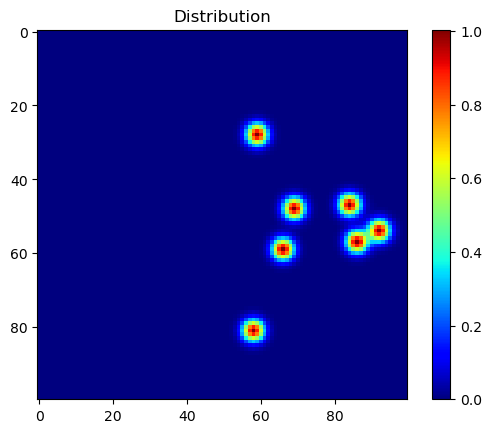

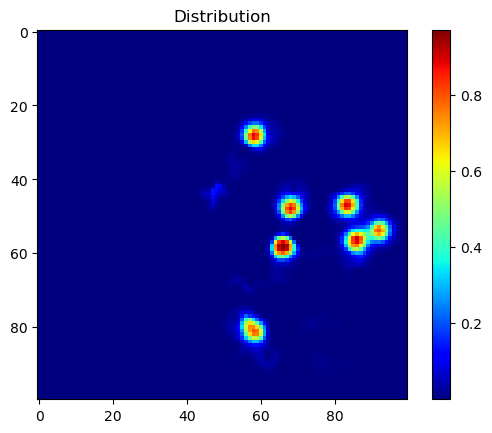

tensor([[-1.0581,  1.2172, -0.9099, -0.1761,  0.0295, -0.6032,  0.8073,  2.3009,
          1.9602, -0.7964]], grad_fn=<AddmmBackward0>) tensor([[-4.3358, -4.2076, -4.5104, -5.0270, -3.2193, -5.2406, -5.0818, -3.0656,
         -2.7779, -3.4096]], grad_fn=<AddmmBackward0>)


In [95]:
from dataset import MyDataset
from torch.utils.data import DataLoader
from generator.utils_ import Distribution
from sklearn.model_selection import train_test_split

latent_dims = 100
granularity = 0.01
dataset = MyDataset(csv_file="merged.csv",
                    distributionGranurality=granularity)

train_dataset, test_dataset = train_test_split(
    dataset, test_size=0.2, random_state=42)

test_dataset = DataLoader(
    test_dataset, batch_size=1, shuffle=True)

sample = next(iter(test_dataset))
x = sample["distribution"]
x = x.view(-1, x.size(1)**2)
t = sample["team"]
bp = sample["ballPosition"]
bc = sample["ballControl"]

x_hat, mu, logvar = model(x, t, bp, bc)
x_hat = x_hat.view(100, 100).detach().numpy()
x = x.view(100,100)


Distribution.plot(x)
Distribution.plot(x_hat)

print(mu, logvar)

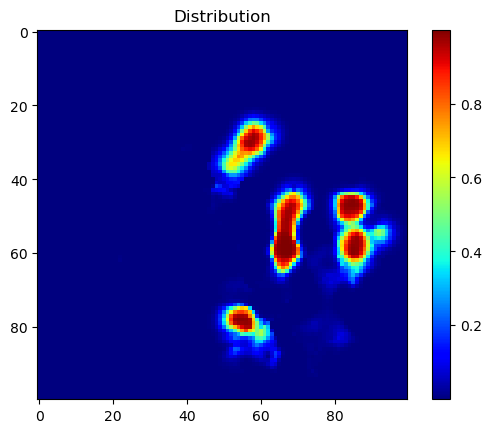

In [96]:

logvar = torch.rand_like(logvar)
mu = torch.rand_like(mu)
std = torch.exp(0.5 * logvar)
z = torch.randn_like(std) * std + mu
x_perturb = model.decoder(z, t, bp, bc)
x_perturb = x_perturb.view(100, 100).detach().numpy()

Distribution.plot(x_perturb)

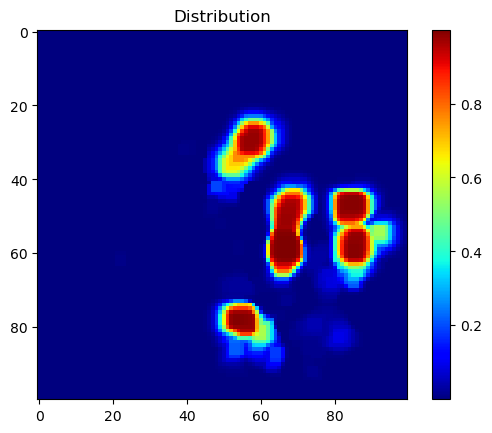

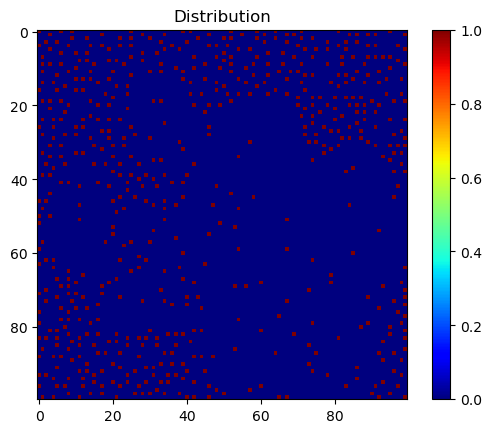

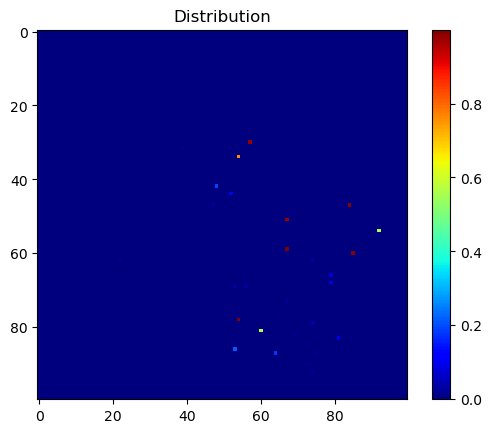

In [97]:
mp = torch.nn.MaxPool2d(3, 1, 1)
tt = torch.tensor(x_perturb)
nms = mp(tt.unsqueeze(0)).squeeze().detach().numpy()
candidates = nms == x_perturb
Distribution.plot(nms)
Distribution.plot(candidates)
res = nms*candidates
Distribution.plot(res)

54 78 0.9930062
67 59 0.9996768
84 47 0.99181247
85 60 0.9911299
57 30 0.97953564
67 51 0.9738479
54 34 0.7576586


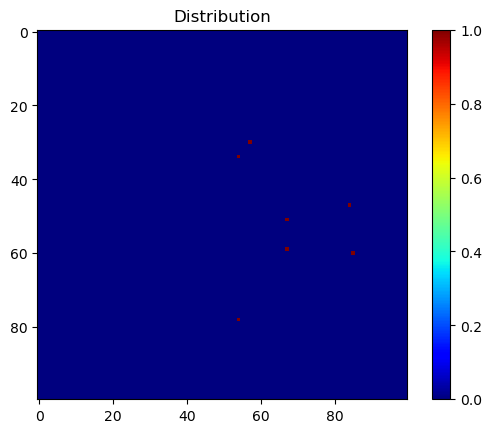

In [101]:
import numpy as np

def topk(matrix, k):
    # every pair is x,y and the list
    flat_indices = np.argpartition(matrix.flatten(), -k)[-k:]
    topk_indices = np.unravel_index(flat_indices, matrix.shape)
    t = np.transpose(topk_indices)
    out = [list(reversed(pair)) for pair in t]
    return list(reversed(out))


topkCoord = topk(res,7)
generatedPositions = np.zeros((100,100))
for l in topkCoord:
    x,y = l
    generatedPositions[y,x] = 1.
    print(x,y,x_perturb[y,x])
Distribution.plot(generatedPositions)